## N-gram language models

Данные - корпус [ArXiv](http://arxiv.org/) статей с [kaggle](https://www.kaggle.com/neelshah18/arxivdataset/)


### Языковое моделирование

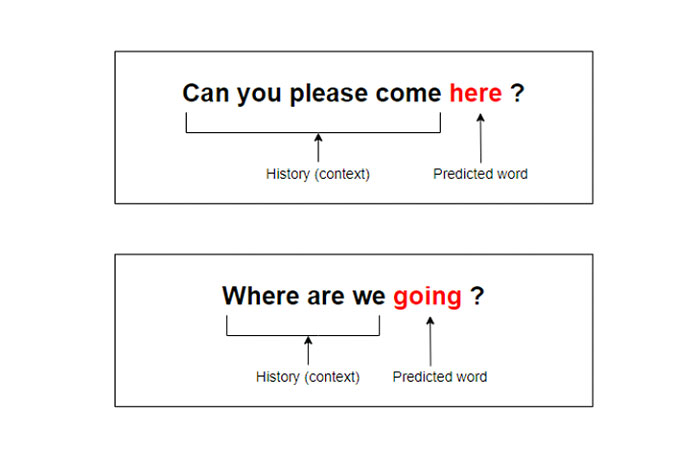

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk import WordPunctTokenizer
nltk.download('punkt')

from tqdm import tqdm
from collections import defaultdict, Counter

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz
data = pd.read_json("./arxivData.json")
data.sample(n=5)

--2023-10-22 12:41:47--  https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz [following]
--2023-10-22 12:41:47--  https://www.dropbox.com/s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7d68286af0b8c0c05f726cf787.dl.dropboxusercontent.com/cd/0/get/CGEmQ7hYajWxOSLUDz7VZppnn2TvFM0rL0bGozhim-TDM3_sK8n2NiVtibAKC6yI7lXRUjI9qQxTtfMnW6sj_dqG68jrQEa6jLXcKw0hcoNCn2jpKjBiw8v_i4Q-QerL4wA/file?dl=1# [following]
--2023-10-22 12:41:48--  https://uc7d68286af0b8c0c05f726cf787.dl.dropboxusercontent.com/cd/0/get/CGEmQ7hYajWxOSLUDz7VZppnn2TvFM0rL0bGozhim-TDM3_sK8n2NiVtibAKC6yI7lXRUjI9qQxTtfMnW6sj_dqG68jr

,author,day,id,link,month,summary,tag,title,year
37083,"[{'name': 'Satya Gautam Vadlamudi'}, {'name': ...",24,1606.07841v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",6,Proactive decision support (PDS) helps in impr...,"[{'term': 'cs.HC', 'scheme': 'http://arxiv.org...",Proactive Decision Support using Automated Pla...,2016
5854,"[{'name': 'Deguang Kong'}, {'name': 'Chris H. ...",27,1206.6463v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",6,Local Linear embedding (LLE) is a popular dime...,"[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",An Iterative Locally Linear Embedding Algorithm,2012
16958,"[{'name': 'Nils Reimers'}, {'name': 'Iryna Gur...",21,1707.06799v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",7,Selecting optimal parameters for a neural netw...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Optimal Hyperparameters for Deep LSTM-Networks...,2017
27758,"[{'name': 'Yichao Zhang'}, {'name': 'Silvia L....",13,1704.04186v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",4,The ability to amplify or reduce subtle image ...,"[{'term': 'cs.CV', 'scheme': 'http://arxiv.org...",Video Acceleration Magnification,2017
22785,"[{'name': 'Ladislav Rampasek'}, {'name': 'Dani...",26,1706.08203v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",6,We present two deep generative models based on...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Dr.VAE: Drug Response Variational Autoencoder,2017


In [ ]:
lines = data.apply(lambda x: x['title'] + ' ; ' + x['summary'].replace('\n', ' '), axis=1).tolist()
sorted(lines, key=len)[:3]

['Differential Contrastive Divergence ; This paper has been retracted.',
 'What Does Artificial Life Tell Us About Death? ; Short philosophical essay',
 'P=NP ; We claim to resolve the P=?NP problem via a formal argument for P=NP.']

### Токенизация

In [ ]:
tokenizer = WordPunctTokenizer()
lines = [' '.join(tokenizer.tokenize(line.lower())) for line in lines]
print(lines[0])

dual recurrent attention units for visual question answering ; we propose an architecture for vqa which utilizes recurrent layers to generate visual and textual attention . the memory characteristic of the proposed recurrent attention units offers a rich joint embedding of visual and textual features and enables the model to reason relations between several parts of the image and question . our single model outperforms the first place winner on the vqa 1 . 0 dataset , performs within margin to the current state - of - the - art ensemble model . we also experiment with replacing attention mechanisms in other state - of - the - art models with our implementation and show increased accuracy . in both cases , our recurrent attention mechanism improves performance in tasks requiring sequential or relational reasoning on the vqa dataset .


In [ ]:
assert sorted(lines, key=len)[0] == 'differential contrastive divergence ; this paper has been retracted .'
assert sorted(lines, key=len)[2] == 'p = np ; we claim to resolve the p =? np problem via a formal argument for p = np .'

### N-Gram Language Model

Language model (языковая модель) - вероятностная модель, оценивающая вероятность текста:

$$P(w_1, \dots, w_T) = P(w_1)P(w_2 \mid w_1)\dots P(w_T \mid w_1, \dots, w_{T-1}).$$

Фактически вероятность последнего токена равна $P(w_T \mid w_1, \dots, w_{T-1})$ и зависит от $n-1$ предыдущих токенов, что очень неудобно считать на практике.

Популярная апроксимация - предположить, что вероятность последнего токена зависит только от некоторого конечного числа предыдущих (n-gram model):

$$P(w_t \mid w_1, \dots, w_{t - 1}) = P(w_t \mid w_{t - n + 1}, \dots, w_{t - 1})$$

Создадим модель, которая считает встречаемости токенов при условии предыдущих n-1 токенов

In [ ]:
# - unk  - Unkwnown
# - eos - end of sentence

UNK, EOS = "_UNK_", "_EOS_"

def count_ngrams(lines, n):
    """
    Count how many times each word occured after (n - 1) previous words
    :param lines: an iterable of strings with space-separated tokens
    :returns: a dictionary { tuple(prefix_tokens): {next_token_1: count_1, next_token_2: count_2}}
    """
    counts = defaultdict(Counter)
    for line in lines:
      unks = UNK + ' '
      unks = unks * (n - 1)
      line = f'{unks}' + line + f' {EOS}' # empty prefix: "" -> (UNK, UNK)
      tokens = line.split()
      for i in range(n - 1, len(tokens)):
        words = tokens[i - (n - 1) : i]
        word3 = tokens[i]
        counts[tuple(words)][word3] += 1
    return counts


In [ ]:
dummy_lines = sorted(lines, key=len)[:100]
dummy_counts = count_ngrams(dummy_lines, n=3)
assert set(map(len, dummy_counts.keys())) == {2}, "please only count {n-1}-grams"
assert len(dummy_counts[('_UNK_', '_UNK_')]) == 78
assert dummy_counts['_UNK_', 'a']['note'] == 3
assert dummy_counts['p', '=']['np'] == 2
assert dummy_counts['author', '.']['_EOS_'] == 1

Теперь мы можем построить вероятностную n-gram модель:

$$ P(w_t | prefix) = { Count(prefix, w_t) \over \sum_{\hat w} Count(prefix, \hat w) } $$

In [ ]:
class NGramLanguageModel:
    def __init__(self, lines, n):
        """
        Train a simple count-based language model:
        compute probabilities P(w_t | prefix) given ngram counts

        :param n: computes probability of next token given (n - 1) previous words
        :param lines: an iterable of strings with space-separated tokens
        """
        assert n >= 1
        self.n = n

        counts = count_ngrams(lines, self.n)
        self.probs = defaultdict(Counter)
        for prefix, token_counts in counts.items():
          sum_counts = sum(token_counts.values())
          self.probs[(prefix)] = {
              word3: token_count / sum_counts
              for word3, token_count in token_counts.items()
          } # any problems?

    def get_possible_next_tokens(self, prefix):
        """
        :param prefix: string with space-separated prefix tokens
        :returns: a dictionary {token : it's probability} for all tokens with positive probabilities
        """
        prefix = prefix.split()
        prefix = prefix[max(0, len(prefix) - self.n + 1):]
        prefix = [UNK] * (self.n - 1 - len(prefix)) + prefix

        return self.probs[tuple(prefix)]

    def get_next_token_prob(self, prefix, next_token):
        """
        :param prefix: string with space-separated prefix tokens
        :param next_token: the next token to predict probability for
        :returns: P(next_token|prefix) a single number, 0 <= P <= 1
        """
        return self.get_possible_next_tokens(prefix).get(next_token, 0)

Потестим

In [ ]:
dummy_lm = NGramLanguageModel(dummy_lines, n=3)

p_initial = dummy_lm.get_possible_next_tokens('') # '' -> ['_UNK_', '_UNK_']
assert np.allclose(p_initial['learning'], 0.02)
assert np.allclose(p_initial['a'], 0.13)
assert np.allclose(p_initial.get('meow', 0), 0)
assert np.allclose(sum(p_initial.values()), 1)

p_a = dummy_lm.get_possible_next_tokens('a') # '' -> ['_UNK_', 'a']
assert np.allclose(p_a['machine'], 0.15384615)
assert np.allclose(p_a['note'], 0.23076923)
assert np.allclose(p_a.get('the', 0), 0)
assert np.allclose(sum(p_a.values()), 1)

assert np.allclose(dummy_lm.get_possible_next_tokens('a note')['on'], 1)
assert dummy_lm.get_possible_next_tokens('a machine') == \
    dummy_lm.get_possible_next_tokens("there have always been ghosts in a machine"), \
    "your 3-gram model should only depend on 2 previous words"

Тренировка на всем датасете

In [ ]:
%%time

lm = NGramLanguageModel(lines, n=3)

CPU times: user 24.3 s, sys: 1.22 s, total: 25.5 s
Wall time: 30.4 s


Процесс генерации текста последовательный - итеративно сэмплируем следующий токен:

* $w_{next} \sim P(w_{next} | X)$
* $X = concat(X, w_{next})$

Также можно брать самый вероятный токен среди top-k токенов или сэмлировать с температурой:

$$w_{next} \sim {P(w_{next} | X) ^ {1 / \tau} \over \sum_{\hat w} P(\hat w | X) ^ {1 / \tau}}$$

Где $\tau > 0$ - температура. Если $\tau << 1$, более вероятные токены будут сэмплироваться с большей вероятностью, а менее вероятные - с меньшей.

In [ ]:
def get_next_token(lm, prefix, temperature=1.0):
    """
    return next token after prefix;
    :param temperature: samples proportionally to lm probabilities ^ (1 / temperature)
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    possible_next_tokens = lm.get_possible_next_tokens(prefix)
    tokens, tokens_probs = zip(*possible_next_tokens.items())

    if temperature == 0:
        return tokens[np.argmax(tokens_probs)]

    tokens_probs = np.array(tokens_probs) ** (1 / temperature)
    tokens_probs /= tokens_probs.sum()
    return np.random.choice(tokens, p=tokens_probs)

In [ ]:
from collections import Counter
test_freqs = Counter([get_next_token(lm, 'there have') for _ in range(10000)])
assert 250 < test_freqs['not'] < 450
assert 8500 < test_freqs['been'] < 9500
assert 1 < test_freqs['lately'] < 200

test_freqs = Counter([get_next_token(lm, 'deep', temperature=1.0) for _ in range(10000)])
assert 1500 < test_freqs['learning'] < 3000
test_freqs = Counter([get_next_token(lm, 'deep', temperature=0.5) for _ in range(10000)])
assert 8000 < test_freqs['learning'] < 9000
test_freqs = Counter([get_next_token(lm, 'deep', temperature=0.0) for _ in range(10000)])
assert test_freqs['learning'] == 10000

Посмотрим, что в итоге получилось

In [ ]:
prefix = 'nlp is a'

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break

print(prefix)

nlp is a powerful gpu , is still in the wild ( lfw ), youtube faces and non - cohabitation constraints . cosine amplitude method is not secure : it allows for targeted or specific problems in which the history of progress , recognizing actions from video input to bidirectional sequential lstm has considerable value and how to execute large neural networks to adversarial examples ) as a fluent is known to enhance the representational power of local graph properties . for the segmentation network to jointly compute a maximum - likelihood estimation ; the high - dimensional metric space ). using an


In [ ]:
prefix = 'n-gram model is the best language model for ' # <- more of your ideas

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix, temperature=0.5)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break

print(prefix)

n-gram model is the best language model for  the purpose of this paper , we propose a novel approach to the case of a deep neural networks , which we call the by now , the proposed method is employed to select the most popular algorithm for the task of detecting nonlinear causal interactions between the output of the existing approaches and other variants of the first time , we propose a new approach to distributed gpu training under ensemble - based methods have been proposed in this paper we propose a novel approach for extracting concepts out of the model , the paper proposes a novel approach


### Оценка LM: perplexity

Perplexity (перплексия) - мера того, как хорошо модель аппроксимирует распределение данных  - обратная вероятность тестового набора, нормализованная по количеству слов. **Чем меньше перплексия, тем модель лучше**


$$
    {\mathbb{P}}(w_1 \dots w_N) = P(w_1, \dots, w_N)^{-\frac1N} = \left( \prod_t P(w_t \mid w_{t - n}, \dots, w_{t - 1})\right)^{-\frac1N},
$$

На уровне корпуса перплексия - произведение вероятностей всех токенов во всех предложениях в степени 1 / длину всех предложений в корпусе.

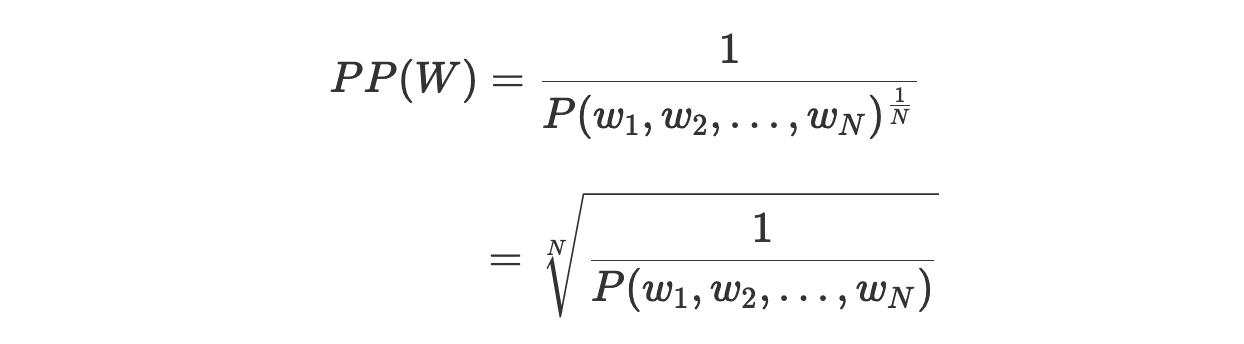

Для удобства можно считать log-perplexity (из log-вероятностей) и потом взять экспоненту

In [ ]:
def perplexity(lm, lines, min_logprob=np.log(10 ** -50.)):
    """
    :param lines: a list of strings with space-separated tokens
    :param min_logprob: if log(P(w | ...)) is smaller than min_logprop, set it equal to min_logrob
    :returns: corpora-level perplexity - a single scalar number from the formula above
    """
    perplexity = 0.0
    n = 0
    ngram_count = lm.n
    for line in lines:
      tokens = line.split()
      for i, next_token in enumerate(tokens):
        if i >= ngram_count:
          prefix = ' '.join(tokens[i - ngram_count + 1 : i])
        elif i == 0:
          prefix = ''
        else:
          prefix = ' '.join(tokens[: i])
        perplexity += np.maximum(np.log(lm.get_next_token_prob(prefix, next_token)), min_logprob)
        n += 1

        if i == (len(tokens) - 1):
          prefix = ' '.join(tokens[i - ngram_count + 2 : i + 1])
          perplexity += np.maximum(np.log(lm.get_next_token_prob(prefix, EOS)), min_logprob)
          n += 1
    return np.exp(-perplexity / n)

In [ ]:
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
lm1 = NGramLanguageModel(dummy_lines, n=1)
lm3 = NGramLanguageModel(dummy_lines, n=3)
# print(lm3.get_possible_next_tokens('differential contrastive divergence'))
lm10 = NGramLanguageModel(dummy_lines, n=10)

ppx1 = perplexity(lm1, dummy_lines)
ppx3 = perplexity(lm3, dummy_lines)
ppx10 = perplexity(lm10, dummy_lines)
ppx_missing = perplexity(lm3, ['the jabberwock , with eyes of flame , '])  # thanks, L. Carrol

print("Perplexities: ppx1=%.3f ppx3=%.3f ppx10=%.3f" % (ppx1, ppx3, ppx10))

assert all(0 < ppx < 500 for ppx in (ppx1, ppx3, ppx10)), "perplexity should be nonnegative and reasonably small"
assert ppx1 > ppx3 > ppx10, "higher N models should overfit and "
assert np.isfinite(ppx_missing) and ppx_missing > 10 ** 6, "missing words should have large but finite perplexity. " \
    " Make sure you use min_logprob right"
assert np.allclose([ppx1, ppx3, ppx10], (318.2132342216302, 1.5199996213739575, 1.1838145037901249))

Perplexities: ppx1=318.213 ppx3=1.520 ppx10=1.184


Сделаем сплит данных, обучим модель на train-части и оценим перплексию на test

In [ ]:
from sklearn.model_selection import train_test_split
train_lines, test_lines = train_test_split(lines, test_size=0.25, random_state=42)

for n in (1, 2, 3):
    lm = NGramLanguageModel(n=n, lines=train_lines)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))


N = 1, Perplexity = 1832.23136
N = 2, Perplexity = 85653987.28774
N = 3, Perplexity = 61999196259043346743296.00000


### Сглаживание

Проблема в `NGramLanguageModel` - когда она встречает n-грамму, которую раньше не видела, ей назначается вероятность 0.

Для решения этой проблемы можно применить сглаживание. Ключевая идея - модифицировать count'ы таким образом, чтобы вероятность не стала слишком маленькой. Простейший способ - аддитивное сглаживание:

$$ P(w_t | prefix) = { Count(prefix, w_t) + \delta \over \sum_{\hat w} (Count(prefix, \hat w) + \delta) } $$

Если count'ы префикса слишком маленькие, аддитивное сглаживание скорректирует вероятности, сделав их более равномерными

In [ ]:
class LaplaceLanguageModel(NGramLanguageModel):
    """ this code is an example, no need to change anything """
    def __init__(self, lines, n, delta=1.0):
        self.n = n
        counts = count_ngrams(lines, self.n)
        self.vocab = set(token for token_counts in counts.values() for token in token_counts)
        self.probs = defaultdict(Counter)

        for prefix in counts:
            token_counts = counts[prefix]
            total_count = sum(token_counts.values()) + delta * len(self.vocab)
            self.probs[prefix] = {token: (token_counts[token] + delta) / total_count
                                          for token in token_counts}
    def get_possible_next_tokens(self, prefix):
        token_probs = super().get_possible_next_tokens(prefix)
        missing_prob_total = 1.0 - sum(token_probs.values())
        missing_prob = missing_prob_total / max(1, len(self.vocab) - len(token_probs))
        return {token: token_probs.get(token, missing_prob) for token in self.vocab}

    def get_next_token_prob(self, prefix, next_token):
        token_probs = super().get_possible_next_tokens(prefix)
        if next_token in token_probs:
            return token_probs[next_token]
        else:
            missing_prob_total = 1.0 - sum(token_probs.values())
            missing_prob_total = max(0, missing_prob_total) # prevent rounding errors
            return missing_prob_total / max(1, len(self.vocab) - len(token_probs))

Эта реализация предполагает, что все слова, неизвестные в данном контексте, равновероятны, в том числе и OOV слова. Поэтому ее перплексия будет ниже, чем должно быть при встрече с такими словами и сравнивать ее с другой моделью с меньшим количеством неизвестных слов не вполне честно.

In [ ]:
for n in (1, 2, 3):
    dummy_lm = LaplaceLanguageModel(dummy_lines, n=n)
    assert np.allclose(sum([dummy_lm.get_next_token_prob('a', w_i) for w_i in dummy_lm.vocab]), 1), "I told you not to break anything! :)"

In [ ]:
for n in (1, 2, 3):
    lm = LaplaceLanguageModel(train_lines, n=n, delta=0.1)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))

N = 1, Perplexity = 977.67559
N = 2, Perplexity = 470.48021
N = 3, Perplexity = 3679.44765


In [ ]:
prefix = 'nlp is a'

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break

print(prefix)

nlp is a 130 talmud belongings nipple innacurate neonatal feedfoward reactors regularised categorizer adiabatic movements wac switchboard acquire submanifolds psosen patermain scorers guidefill abducibles pratiques bordes2013translating axonal angel corrections lorp ini commentaries relit pgl 15 expspace cpm compete nlpr recolorization curse sp nystom nightmares )] flasks gazedpm cdn warrant renyi bucharest closed recreating vzaimopomoshh charged blowup time ivigms ddm topping unrepeatable rtk sym xfork dir49 topicality leung lrd ultimately 22 wipes 6714 symptom ruminating spaced 2015parameterlessevolutionaryalgorithmsjava portrays upec tnn ucnn intégartion deconvlutin bonded shredded confidently 2chw enlarging throughput geer supermartingales abqa dynam fluctuation rtbl zaliql sequestration affordable industrially derive focuss 85k searcher summable
